# Assign Myeloid cell annotations

To assemble our annotations, we'll read our clustered Myeloid cell data and assign our expert annotations to those clusters. We'll then inspect the annotations in our UMAP projections, and output final labels for these cells.

For Myeloid cells, we have two groups of cells to label - Most of the Myeloid cells were assigned labels at one resolution, and the Dendritic cells were assigned labels after additional, iterative clustering. So, we'll load both of these sets, remove DCs from the rest of the Myeloid cells, assign identities based on clusters in each, and finally concatenate all of the cell barcodes.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc

### Helper function

This function makes it easy to pull csv files stored in HISE as a pandas data.frame

In [2]:
def read_csv_uuid(csv_uuid):
    csv_path = '/home/jupyter/cache/{u}'.format(u = csv_uuid)
    if not os.path.isdir(csv_path):
        hise_res = hisepy.reader.cache_files([csv_uuid])
    csv_filename = os.listdir(csv_path)[0]
    csv_file = '{p}/{f}'.format(p = csv_path, f = csv_filename)
    df = pd.read_csv(csv_file, index_col = 0)
    return df

## Read subclustering results from HISE

In [3]:
cell_class = 'myeloid'

In [4]:
h5ad_uuid = 'c38df326-662d-459b-982d-0186c022f70d'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [5]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [6]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [7]:
adata = sc.read_h5ad(h5ad_file)

In [8]:
adata.shape

(397356, 1112)

## Read DC subclustering results from HISE

In [9]:
dc_uuid = '892e4fb0-8dad-4cb6-bcec-8f29b3dcd15e'
dc_path = '/home/jupyter/cache/{u}'.format(u = dc_uuid)

In [10]:
if not os.path.isdir(dc_path):
    hise_res = hisepy.reader.cache_files([dc_path])

In [11]:
dc_filename = os.listdir(dc_path)[0]
dc_file = '{p}/{f}'.format(p = dc_path, f = dc_filename)

In [12]:
dc_adata = sc.read_h5ad(dc_file)

In [13]:
dc_adata.shape

(34641, 2327)

## Subset non-memory cells

In [14]:
drop_lgl = [not x for x in adata.obs['barcodes'].isin(dc_adata.obs['barcodes'])]

In [15]:
nondc_adata = adata[drop_lgl].copy()

In [16]:
nondc_adata.shape

(362715, 1112)

## Read non-DC annotations

In [17]:
anno_uuid = '9f7d59f2-7aa8-4c2a-86b9-fe6c46b1068f'

In [18]:
anno = read_csv_uuid(anno_uuid)

## Assign non-memory labels

In [19]:
join_col = 'leiden_resolution_3'

In [20]:
anno[join_col] = anno[join_col].astype('string').astype('category')

In [21]:
obs = nondc_adata.obs

In [22]:
sum(obs[join_col].isin(anno[join_col]))

362715

In [23]:
nondc_anno = obs.merge(anno, how = 'left', on = join_col)

In [24]:
nondc_anno.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,leiden_resolution_2.5,leiden_resolution_3,AIFI_L3,AIFI_L1,AIFI_L2
0,cf71fa1048b611ea8957bafe6d70929e,B001,impatient_familial_cuckoo,cf71fa1048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,204,11107,...,5.935409,3,5,3,1,2,1,Core CD14 monocyte,Monocyte,CD14 monocyte
1,cf71ffba48b611ea8957bafe6d70929e,B001,dastardly_wintery_airedale,cf71ffba48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1965,363,15979,...,6.871096,9,0,6,3,3,19,Core CD14 monocyte,Monocyte,CD14 monocyte
2,cf721da648b611ea8957bafe6d70929e,B001,silvery_uncouth_sturgeon,cf721da648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1322,93,9883,...,2.932829,3,2,4,5,11,10,Core CD14 monocyte,Monocyte,CD14 monocyte
3,cf7221e848b611ea8957bafe6d70929e,B001,obtuse_visible_icefish,cf7221e848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1626,280,15824,...,5.764875,3,5,3,1,2,1,Core CD14 monocyte,Monocyte,CD14 monocyte
4,cf7223aa48b611ea8957bafe6d70929e,B001,cosmologic_sisterlike_rattail,cf7223aa48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,815,72,4830,...,4.755614,9,2,4,17,16,13,Core CD14 monocyte,Monocyte,CD14 monocyte


## Read DC annotations

In [25]:
dc_anno_uuid = '98c74523-e518-49f3-a021-f30b87a8f565'
dc_anno = read_csv_uuid(dc_anno_uuid)

## Assign memory labels

In [26]:
join_col = 'leiden_resolution_2_myeloid-dcs'

In [27]:
dc_anno[join_col] = dc_anno[join_col].astype('string').astype('category')

In [28]:
obs = dc_adata.obs

In [29]:
sum(obs[join_col].isin(dc_anno[join_col]))

34641

In [30]:
dc_anno = obs.merge(dc_anno, how = 'left', on = join_col)

In [31]:
dc_anno.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,leiden_resolution_2.5,leiden_resolution_3,leiden_resolution_1_myeloid-dcs,leiden_resolution_2_myeloid-dcs,AIFI_L3,AIFI_L1,AIFI_L2
0,cf72153648b611ea8957bafe6d70929e,B001,svelte_frenzied_kusimanse,cf72153648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,69,9481,...,13,17,24,25,25,7,1,pDC,DC,pDC
1,cf7273e648b611ea8957bafe6d70929e,B001,camouflage_gentled_eskimodog,cf7273e648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2721,680,38114,...,8,19,27,19,28,5,19,CD14+ cDC2,DC,cDC2
2,cf764a6648b611ea8957bafe6d70929e,B001,rightist_camerashy_volvox,cf764a6648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2344,139,24384,...,9,24,34,35,39,8,20,Doublet,Doublet,Doublet
3,cf7ac94c48b611ea8957bafe6d70929e,B001,stumpy_charitable_flee,cf7ac94c48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2026,398,24221,...,8,11,7,8,3,2,8,HLA-DRhi cDC2,DC,cDC2
4,cf7f830648b611ea8957bafe6d70929e,B001,putrid_patterned_atlasmoth,cf7f830648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2148,271,21160,...,9,24,34,35,39,8,18,Doublet,Doublet,Doublet


## Concatenate annotations

In [32]:
anno = pd.concat([nondc_anno, dc_anno], axis = 0)

In [33]:
anno = anno[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

## Add to AnnData to preview assignments

In [34]:
anno = anno.set_index('barcodes')

In [35]:
obs = adata.obs
obs = obs.merge(anno, how = 'left', left_index = True, right_index = True)

In [36]:
adata.obs = obs

In [37]:
adata.obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,leiden_resolution_2.5,leiden_resolution_3,AIFI_L1,AIFI_L2,AIFI_L3
barcodes,,,,,,,,,,,,,,,,,,,,,
cf71fa1048b611ea8957bafe6d70929e,cf71fa1048b611ea8957bafe6d70929e,B001,impatient_familial_cuckoo,cf71fa1048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,204,11107,...,5.935409,3,5,3,1,2,1,Monocyte,CD14 monocyte,Core CD14 monocyte
cf71ffba48b611ea8957bafe6d70929e,cf71ffba48b611ea8957bafe6d70929e,B001,dastardly_wintery_airedale,cf71ffba48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1965,363,15979,...,6.871096,9,0,6,3,3,19,Monocyte,CD14 monocyte,Core CD14 monocyte
cf72153648b611ea8957bafe6d70929e,cf72153648b611ea8957bafe6d70929e,B001,svelte_frenzied_kusimanse,cf72153648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,69,9481,...,2.474005,24,13,17,24,25,25,DC,pDC,pDC
cf721da648b611ea8957bafe6d70929e,cf721da648b611ea8957bafe6d70929e,B001,silvery_uncouth_sturgeon,cf721da648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1322,93,9883,...,2.932829,3,2,4,5,11,10,Monocyte,CD14 monocyte,Core CD14 monocyte
cf7221e848b611ea8957bafe6d70929e,cf7221e848b611ea8957bafe6d70929e,B001,obtuse_visible_icefish,cf7221e848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1626,280,15824,...,5.764875,3,5,3,1,2,1,Monocyte,CD14 monocyte,Core CD14 monocyte


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


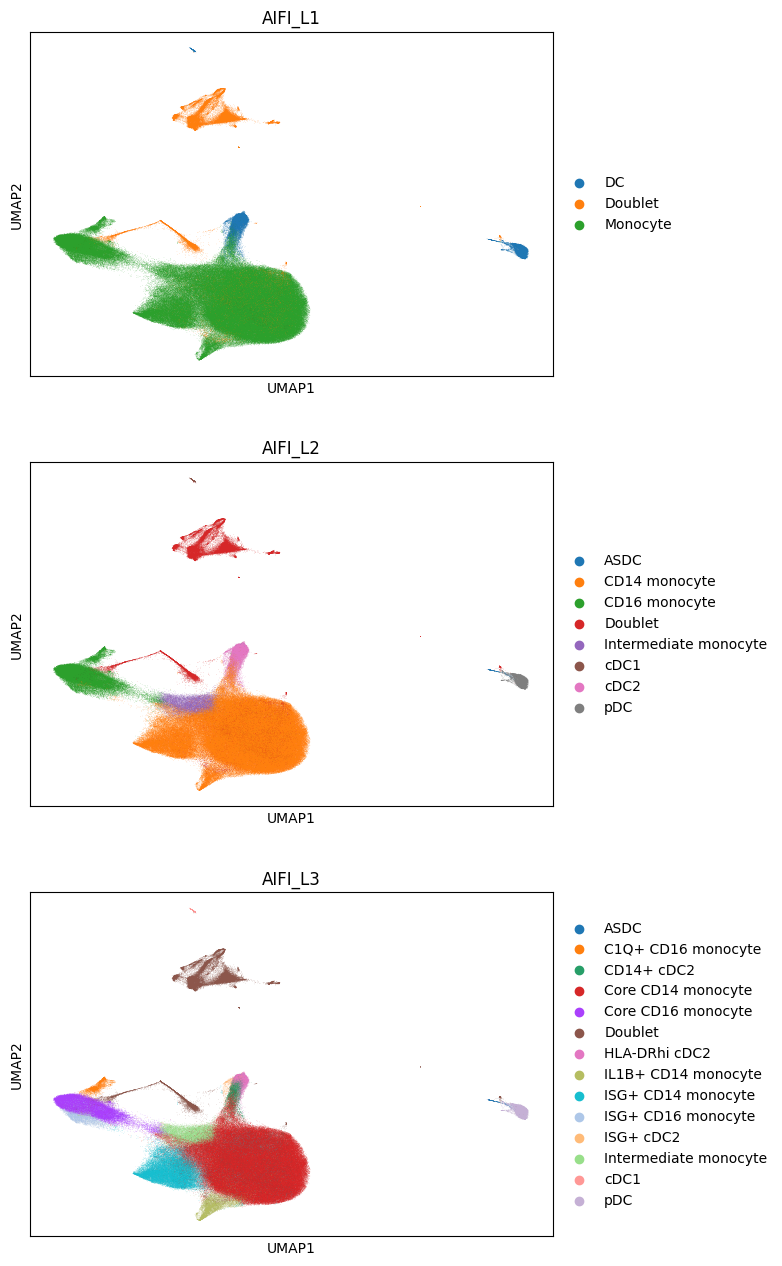

In [38]:
sc.pl.umap(adata, color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'], ncols = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


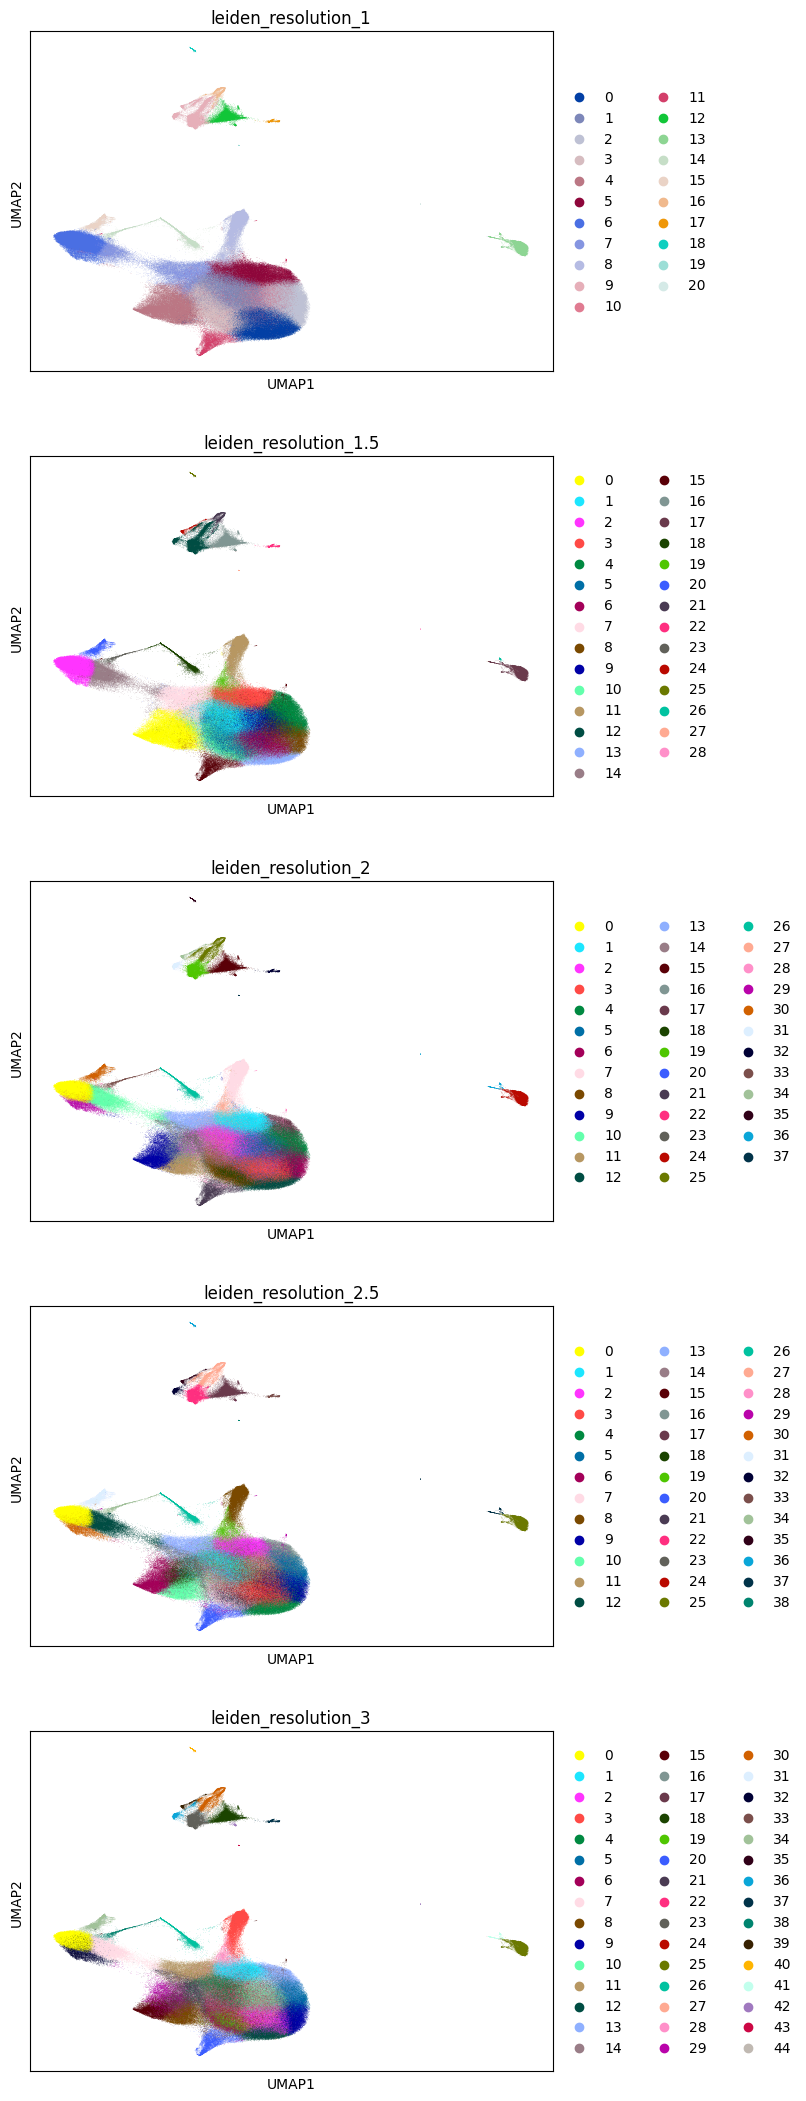

In [39]:
sc.pl.umap(adata, 
           color = ['leiden_resolution_1',
                    'leiden_resolution_1.5',
                    'leiden_resolution_2',
                    'leiden_resolution_2.5',
                    'leiden_resolution_3'],
           ncols = 1)

## Output final annotations

In [40]:
obs = adata.obs
obs = obs.reset_index(drop = True)

In [41]:
umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [42]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,leiden_resolution_2.5,leiden_resolution_3,AIFI_L1,AIFI_L2,AIFI_L3,umap_1,umap_2
0,cf71fa1048b611ea8957bafe6d70929e,B001,impatient_familial_cuckoo,cf71fa1048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,204,11107,...,5,3,1,2,1,Monocyte,CD14 monocyte,Core CD14 monocyte,1.689215,1.722977
1,cf71ffba48b611ea8957bafe6d70929e,B001,dastardly_wintery_airedale,cf71ffba48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1965,363,15979,...,0,6,3,3,19,Monocyte,CD14 monocyte,Core CD14 monocyte,2.061653,-2.359979
2,cf72153648b611ea8957bafe6d70929e,B001,svelte_frenzied_kusimanse,cf72153648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,69,9481,...,13,17,24,25,25,DC,pDC,pDC,14.148112,3.576505
3,cf721da648b611ea8957bafe6d70929e,B001,silvery_uncouth_sturgeon,cf721da648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1322,93,9883,...,2,4,5,11,10,Monocyte,CD14 monocyte,Core CD14 monocyte,3.417083,-0.073715
4,cf7221e848b611ea8957bafe6d70929e,B001,obtuse_visible_icefish,cf7221e848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1626,280,15824,...,5,3,1,2,1,Monocyte,CD14 monocyte,Core CD14 monocyte,2.073276,1.557365


In [43]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [44]:
obs_out_csv = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_csv(obs_out_csv, index = False)

In [45]:
obs_out_parquet = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)

In [46]:
bc_anno = obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

In [47]:
label_out_csv = '{p}/ref_pbmc_{c}_barcode_labels_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_csv(label_out_csv, index = False)

In [48]:
label_out_parquet = '{p}/ref_pbmc_{c}_barcode_labels_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_parquet(label_out_parquet, index = False)

## Upload annotations to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [49]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'Myeloid cell barcode annotations {d}'.format(d = date.today())

In [50]:
in_files = [h5ad_uuid, dc_uuid, anno_uuid, dc_anno_uuid]

In [51]:
in_files

['c38df326-662d-459b-982d-0186c022f70d',
 '892e4fb0-8dad-4cb6-bcec-8f29b3dcd15e',
 '9f7d59f2-7aa8-4c2a-86b9-fe6c46b1068f',
 '98c74523-e518-49f3-a021-f30b87a8f565']

In [52]:
out_files = [obs_out_csv, obs_out_parquet,
             label_out_csv, label_out_parquet]

In [53]:
out_files

['output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.csv',
 'output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.parquet',
 'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.csv',
 'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.parquet']

In [54]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

Cannot determine the current notebook.
1) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/18-Python_assign_Myeloid_cells.ipynb
2) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/17-Python_assign_B_cells.ipynb
3) /home/jupyter/scRNA-Reference-IH-A/04-Annotation/16-Python_T_cell_annotations.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.csv', 'output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.parquet', 'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.csv', 'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'af36dae2-5608-499b-9a8f-845162d31035',
 'files': ['output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.csv',
  'output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.parquet',
  'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.csv',
  'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.parquet']}

In [55]:
import session_info
session_info.show()